## 4-1

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.models import resnet18
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm


c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Custom dataset class
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.samples[idx])
        img = cv2.imread(img_name)
        
        if self.transform:
                img = self.transform(img)
        
        if self.root_dir.split('_')[2]=='train':
            
            label_file = img_name.replace('.png', '.txt')
            with open(label_file, 'r') as f:
                label = int(f.readline()[0])

            return img, label
        else:
            return img, self.samples[idx]

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit


def create_stratified_split(dataset, test_size=0.2):
    labels = []
    for _, label_path in enumerate(dataset.samples):
        label_file = os.path.join(dataset.root_dir, label_path).replace('.png', '.txt')
        with open(label_file, 'r') as f:
            label = int(f.readline().strip()[0])
        labels.append(label)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
    train_idx, valid_idx = next(sss.split(np.zeros(len(labels)), labels))
    return train_idx, valid_idx

# Create dataset
train_dataset = MNISTDataset('../HW2/HW2_MNIST_train', transform=transform)

# If val_flag is true, create stratified split
val_flag = False
if val_flag:
    train_idx, valid_idx = create_stratified_split(train_dataset)

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Create loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)

    num_train_samples = len(train_sampler)
    num_valid_samples = len(valid_sampler)

    print(f'Number of training samples: {num_train_samples}')
    print(f'Number of validation samples: {num_valid_samples}')

else:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    print(f'Number of training samples: {len(train_loader.dataset)}')


Number of training samples: 97396


In [4]:
def count_classes(dataset, indices):
    class_counts = {}
    for idx in indices:
        img_name = os.path.join(dataset.root_dir, dataset.samples[idx])
        label_file = img_name.replace('.png', '.txt')
        with open(label_file, 'r') as f:
            label = int(f.readline().strip()[0])
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

if val_flag:
    # Count classes in the training set
    train_class_counts = count_classes(train_dataset, train_idx)
    print("Training set class counts:", train_class_counts)

    # Count classes in the validation set
    valid_class_counts = count_classes(train_dataset, valid_idx)
    print("Validation set class counts:", valid_class_counts)


In [5]:
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# RNN models
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, rnn_type):
        super(RNNClassifier, self).__init__()
        if rnn_type == 'SimpleRNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)
        # take the last sequence to output
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# hyperparameters
input_size = 256  # patch size (16x16)
hidden_size = [64,64,128]  # RNN hidden layer
num_layers = [2,2,4]  # RNN layers
num_classes = 10  
seq_length = 64  # 圖像轉換成序列的長度 (128x128 圖像分割成8x8塊，每塊16x16)

# define model
models = {
    'SimpleRNN': RNNClassifier(input_size, hidden_size[0], num_layers[0], num_classes, 'SimpleRNN'),
    'LSTM': RNNClassifier(input_size, hidden_size[1], num_layers[1], num_classes, 'LSTM'),
    'GRU': RNNClassifier(input_size, hidden_size[2], num_layers[2], num_classes, 'GRU'),
}

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = {m: optim.Adam(model.parameters(), lr=0.001) for m, model in models.items()}

# function: image to sequence
def image_to_seq(image, block_size=16):
    # segment image into patches 
    patches = image.unfold(2, block_size, block_size).unfold(3, block_size, block_size)
    patches = patches.contiguous().view(image.size(0), -1, block_size*block_size)
    return patches

# training epoch
num_epochs = 20
for model_name, model in models.items():
    print(f'Start training {model_name}:')
    model = model.to(device)
    optimizer = optimizers[model_name]
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        val_loss, val_correct, val_total = 0.0, 0, 0

        
        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(device), labels.to(device)

            images_seq = image_to_seq(images)
            
            outputs = model(images_seq)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        
        train_acc = train_correct / train_total
        
        if val_flag:
            model.eval()
            with torch.no_grad():
                for images, labels in tqdm(valid_loader, desc='Validation'):
                    images, labels = images.to(device), labels.to(device)
                    images_seq = image_to_seq(images)
                    outputs = model(images_seq)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_acc = val_correct / val_total
            print(f'Epoch [{epoch+1}/{num_epochs}], {model_name} Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss / len(valid_loader):.4f}, Val Accuracy: {val_acc:.4f}')
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f'best_{model_name}.pth')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], {model_name} Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}')
    #timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    torch.save(model.state_dict(), f'{model_name}.pth')


Using device: cuda:0
Start training SimpleRNN:


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.92it/s]


Epoch [1/20], SimpleRNN Train Loss: 2.2825, Train Accuracy: 0.1255


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.84it/s]


Epoch [2/20], SimpleRNN Train Loss: 2.2504, Train Accuracy: 0.1362


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.92it/s]


Epoch [3/20], SimpleRNN Train Loss: 2.2518, Train Accuracy: 0.1358


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.88it/s]


Epoch [4/20], SimpleRNN Train Loss: 2.2426, Train Accuracy: 0.1383


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.86it/s]


Epoch [5/20], SimpleRNN Train Loss: 2.3023, Train Accuracy: 0.1164


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.78it/s]


Epoch [6/20], SimpleRNN Train Loss: 2.2499, Train Accuracy: 0.1538


Training: 100%|██████████| 1522/1522 [00:40<00:00, 37.21it/s]


Epoch [7/20], SimpleRNN Train Loss: 2.2357, Train Accuracy: 0.1484


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.92it/s]


Epoch [8/20], SimpleRNN Train Loss: 2.2532, Train Accuracy: 0.1345


Training: 100%|██████████| 1522/1522 [00:40<00:00, 37.16it/s]


Epoch [9/20], SimpleRNN Train Loss: 2.2464, Train Accuracy: 0.1470


Training: 100%|██████████| 1522/1522 [00:41<00:00, 37.10it/s]


Epoch [10/20], SimpleRNN Train Loss: 2.2454, Train Accuracy: 0.1352


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.82it/s]


Epoch [11/20], SimpleRNN Train Loss: 2.2658, Train Accuracy: 0.1284


Training: 100%|██████████| 1522/1522 [00:45<00:00, 33.82it/s]


Epoch [12/20], SimpleRNN Train Loss: 2.2498, Train Accuracy: 0.1360


Training: 100%|██████████| 1522/1522 [00:46<00:00, 33.07it/s]


Epoch [13/20], SimpleRNN Train Loss: 2.2321, Train Accuracy: 0.1462


Training: 100%|██████████| 1522/1522 [00:43<00:00, 34.62it/s]


Epoch [14/20], SimpleRNN Train Loss: 2.2106, Train Accuracy: 0.1523


Training: 100%|██████████| 1522/1522 [00:42<00:00, 36.02it/s]


Epoch [15/20], SimpleRNN Train Loss: 2.2093, Train Accuracy: 0.1539


Training: 100%|██████████| 1522/1522 [00:40<00:00, 37.22it/s]


Epoch [16/20], SimpleRNN Train Loss: 2.1992, Train Accuracy: 0.1808


Training: 100%|██████████| 1522/1522 [00:40<00:00, 37.17it/s]


Epoch [17/20], SimpleRNN Train Loss: 2.2380, Train Accuracy: 0.1465


Training: 100%|██████████| 1522/1522 [00:40<00:00, 37.51it/s]


Epoch [18/20], SimpleRNN Train Loss: 2.2323, Train Accuracy: 0.1541


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.92it/s]


Epoch [19/20], SimpleRNN Train Loss: 2.2321, Train Accuracy: 0.1702


Training: 100%|██████████| 1522/1522 [00:41<00:00, 36.97it/s]


Epoch [20/20], SimpleRNN Train Loss: 2.2495, Train Accuracy: 0.1683
Start training LSTM:


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.33it/s]


Epoch [1/20], LSTM Train Loss: 2.0716, Train Accuracy: 0.2029


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.07it/s]


Epoch [2/20], LSTM Train Loss: 1.1691, Train Accuracy: 0.5479


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.68it/s]


Epoch [3/20], LSTM Train Loss: 0.6153, Train Accuracy: 0.7906


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.52it/s]


Epoch [4/20], LSTM Train Loss: 0.3801, Train Accuracy: 0.8779


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.67it/s]


Epoch [5/20], LSTM Train Loss: 0.2903, Train Accuracy: 0.9072


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.91it/s]


Epoch [6/20], LSTM Train Loss: 0.2359, Train Accuracy: 0.9244


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.49it/s]


Epoch [7/20], LSTM Train Loss: 0.2012, Train Accuracy: 0.9356


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.52it/s]


Epoch [8/20], LSTM Train Loss: 0.1709, Train Accuracy: 0.9451


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.75it/s]


Epoch [9/20], LSTM Train Loss: 0.1497, Train Accuracy: 0.9515


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.29it/s]


Epoch [10/20], LSTM Train Loss: 0.1315, Train Accuracy: 0.9573


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.28it/s]


Epoch [11/20], LSTM Train Loss: 0.1171, Train Accuracy: 0.9615


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.00it/s]


Epoch [12/20], LSTM Train Loss: 0.1043, Train Accuracy: 0.9660


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.18it/s]


Epoch [13/20], LSTM Train Loss: 0.0956, Train Accuracy: 0.9685


Training: 100%|██████████| 1522/1522 [00:50<00:00, 29.96it/s]


Epoch [14/20], LSTM Train Loss: 0.0864, Train Accuracy: 0.9718


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.59it/s]


Epoch [15/20], LSTM Train Loss: 0.0783, Train Accuracy: 0.9743


Training: 100%|██████████| 1522/1522 [00:47<00:00, 32.26it/s]


Epoch [16/20], LSTM Train Loss: 0.0699, Train Accuracy: 0.9773


Training: 100%|██████████| 1522/1522 [00:49<00:00, 30.69it/s]


Epoch [17/20], LSTM Train Loss: 0.0651, Train Accuracy: 0.9787


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.19it/s]


Epoch [18/20], LSTM Train Loss: 0.0597, Train Accuracy: 0.9805


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.14it/s]


Epoch [19/20], LSTM Train Loss: 0.0561, Train Accuracy: 0.9813


Training: 100%|██████████| 1522/1522 [00:50<00:00, 30.12it/s]


Epoch [20/20], LSTM Train Loss: 0.0499, Train Accuracy: 0.9833
Start training GRU:


Training: 100%|██████████| 1522/1522 [00:53<00:00, 28.57it/s]


Epoch [1/20], GRU Train Loss: 1.0421, Train Accuracy: 0.6174


Training: 100%|██████████| 1522/1522 [00:53<00:00, 28.71it/s]


Epoch [2/20], GRU Train Loss: 0.2662, Train Accuracy: 0.9130


Training: 100%|██████████| 1522/1522 [00:52<00:00, 28.91it/s]


Epoch [3/20], GRU Train Loss: 0.1743, Train Accuracy: 0.9440


Training: 100%|██████████| 1522/1522 [00:52<00:00, 29.00it/s]


Epoch [4/20], GRU Train Loss: 0.1334, Train Accuracy: 0.9565


Training: 100%|██████████| 1522/1522 [00:52<00:00, 28.94it/s]


Epoch [5/20], GRU Train Loss: 0.1046, Train Accuracy: 0.9657


Training: 100%|██████████| 1522/1522 [00:52<00:00, 29.00it/s]


Epoch [6/20], GRU Train Loss: 0.0893, Train Accuracy: 0.9705


Training: 100%|██████████| 1522/1522 [00:52<00:00, 29.09it/s]


Epoch [7/20], GRU Train Loss: 0.0722, Train Accuracy: 0.9758


Training: 100%|██████████| 1522/1522 [00:52<00:00, 28.97it/s]


Epoch [8/20], GRU Train Loss: 0.0618, Train Accuracy: 0.9800


Training: 100%|██████████| 1522/1522 [00:52<00:00, 29.02it/s]


Epoch [9/20], GRU Train Loss: 0.0554, Train Accuracy: 0.9813


Training: 100%|██████████| 1522/1522 [00:52<00:00, 28.99it/s]


Epoch [10/20], GRU Train Loss: 0.0468, Train Accuracy: 0.9838


Training: 100%|██████████| 1522/1522 [00:51<00:00, 29.42it/s]


Epoch [11/20], GRU Train Loss: 0.0441, Train Accuracy: 0.9854


Training: 100%|██████████| 1522/1522 [00:51<00:00, 29.53it/s]


Epoch [12/20], GRU Train Loss: 0.0390, Train Accuracy: 0.9867


Training: 100%|██████████| 1522/1522 [00:51<00:00, 29.62it/s]


Epoch [13/20], GRU Train Loss: 0.0359, Train Accuracy: 0.9879


Training: 100%|██████████| 1522/1522 [00:52<00:00, 29.14it/s]


Epoch [14/20], GRU Train Loss: 0.0341, Train Accuracy: 0.9886


Training: 100%|██████████| 1522/1522 [00:52<00:00, 29.26it/s]


Epoch [15/20], GRU Train Loss: 0.0328, Train Accuracy: 0.9887


Training: 100%|██████████| 1522/1522 [00:51<00:00, 29.29it/s]


Epoch [16/20], GRU Train Loss: 0.0327, Train Accuracy: 0.9890


Training: 100%|██████████| 1522/1522 [00:52<00:00, 28.83it/s]


Epoch [17/20], GRU Train Loss: 0.0268, Train Accuracy: 0.9910


Training: 100%|██████████| 1522/1522 [00:53<00:00, 28.52it/s]


Epoch [18/20], GRU Train Loss: 0.0274, Train Accuracy: 0.9907


Training: 100%|██████████| 1522/1522 [00:53<00:00, 28.49it/s]


Epoch [19/20], GRU Train Loss: 0.0278, Train Accuracy: 0.9908


Training: 100%|██████████| 1522/1522 [00:53<00:00, 28.56it/s]

Epoch [20/20], GRU Train Loss: 0.0262, Train Accuracy: 0.9910


In [17]:
# hyperparameters
input_size = 256  # patch size (16x16)
hidden_size = [64,64,128]  # RNN hidden layer
num_layers = [2,2,4]  # RNN layers
num_classes = 10  
seq_length = 64  # 圖像轉換成序列的長度 (128x128 圖像分割成8x8塊，每塊16x16)

# define model
models = {
    'SimpleRNN': RNNClassifier(input_size, hidden_size[0], num_layers[0], num_classes, 'SimpleRNN'),
    'LSTM': RNNClassifier(input_size, hidden_size[1], num_layers[1], num_classes, 'LSTM'),
    'GRU': RNNClassifier(input_size, hidden_size[2], num_layers[2], num_classes, 'GRU'),
}


for model_name, model in models.items():
    model_path = f'{model_name}.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    train_total = 0
    train_correct = 0 
    train_acc = 0
    with torch.no_grad():
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            images_seq = image_to_seq(images)
            outputs = model(images_seq)
            _, predicted = torch.max(outputs.data, 1)

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            
        train_acc = train_correct / train_total
    
    print(f'{model_name} train accuracy: {train_acc:.4f}')
        

100%|██████████| 1522/1522 [00:38<00:00, 39.10it/s]


SimpleRNN train accuracy: 0.1552


100%|██████████| 1522/1522 [00:39<00:00, 38.13it/s]


LSTM train accuracy: 0.9858


100%|██████████| 1522/1522 [00:48<00:00, 31.65it/s]

GRU train accuracy: 0.9918


### 三個模型的訓練預測結果比較

#### RNN
- 我的 RNN hidden size 設為 64 ， num_layers 設為 2 
- 從整個訓練的過程來看，training loss 無法有效下降，可能是遇到**梯度消失**的問題，因為自己也有試過其他參數跑 RNN，結果大同小異，training loss 都無法有效地減少。
- 在整個訓練集訓練後的預測結果為準確度 **0.1552** (我也有嘗試切 80% 訓練集 20% 驗證集，其在驗證集的表現度，也大約是十幾%)

#### LSTM
- 我的 LSTM hidden size 設為 64 ， num_layers 設為 2 
- LSTM 引入了 cell vector $C(t)$， 透過**線性相加**的方式可以使梯度更好的被傳遞，解決了RNN可能遇到梯度消失的問題。
- 從整個訓練的過程來看，training accuracy 每一個 epoch 都有在提升，直到 10 個 epochs 以後，成長才趨於平緩 
- 在整個訓練集訓練後的預測結果為準確度 **0.9858** (我也有嘗試切 80% 訓練集 20% 驗證集，其在驗證集的表現度，也有達到 93%)

#### GRU
- 我的 LSTM hidden size 設為 128 ， num_layers 設為 4 
- GRU 繼承了 LSTM 容易傳播梯度的特點，同時又**減少了學習參數與計算量**
- 從整個訓練的過程來看，training accuracy 在第一個 epoch 提升很快，之後每個 epoch 也是有在穩定成長 
- 在整個訓練集訓練後的預測結果為準確度 **0.9918** (我也有嘗試切 80% 訓練集 20% 驗證集，其在驗證集的表現度，也有達到 96%)

#### 分析：
資料集類似 MNIST，在圖片中完全黑暗的 patch，RNN 模型可能因梯度消失或無法順利傳遞，導致此模型訓練的結果不是很好。
而我使用了 GRU 作為我最後預測出 HW4_prob1.csv 的模型，因我實驗結果做出比 LSTM 好，可能原因為我使用的參數較多，也可能此資料集較適合使用 GRU，因有文獻指出，在大量資料集下，LSTM 的表現度可能超越 RNN 與 GRU。

In [18]:
# Number of layers and parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(models['SimpleRNN'])
print("Number of trainable parameters(SimpleRNN): ", num_parameters)

num_parameters = count_parameters(models['LSTM'])
print("Number of trainable parameters(LSTM): ", num_parameters)

num_parameters = count_parameters(models['GRU'])
print("Number of trainable parameters(GRU): ", num_parameters)


Number of trainable parameters(SimpleRNN):  29578
Number of trainable parameters(LSTM):  116362
Number of trainable parameters(GRU):  446730


In [37]:
test_dataset = MNISTDataset('../HW2/HW2_MNIST_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = RNNClassifier(256, 128, 4, 10, 'GRU')

# load model
model_path = 'GRU.pth'  
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)


# Perform predictions on the test set
model.eval()  
predictions = []
image_files = []

with torch.no_grad():
    for data in tqdm(test_loader):
        images, file_names = data
        images = images.to(device)
        images_seq = image_to_seq(images)
        outputs = model(images_seq)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        image_files.extend(file_names)

# Save to CSV
predictions_df = pd.DataFrame({
    'image': image_files,
    'class': predictions
})
predictions_df.to_csv('HW4_prob1.csv', index=False)

100%|██████████| 381/381 [00:10<00:00, 36.56it/s]


## 4.2

Epoch [100/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


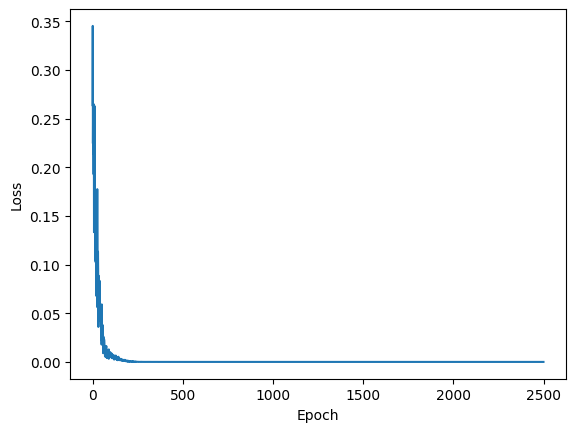

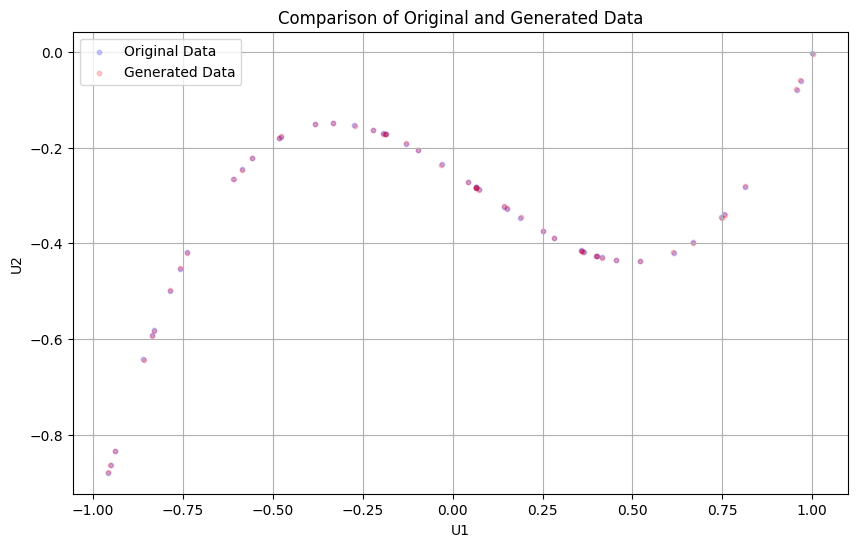

In [32]:
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

data_path = './HW4_prob2.csv'
data = pd.read_csv(data_path)

# data
X = torch.tensor(data.values, dtype=torch.float32)

# use data as inputs and outputs
dataset = TensorDataset(X, X)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# define model
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        return self.network(x)


input_size = X.size(1)
hidden_size = 50  
output_size = input_size  
model = Generator(input_size, hidden_size, output_size)

# loss function and optimizer
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 500  
losses = []  
for epoch in range(num_epochs):
    for batch_features, _ in data_loader:
        
        batch_features = batch_features.to(torch.float32)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        losses.append(loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

with torch.no_grad():
    new_data = model(X).numpy()

plt.figure(figsize=(10, 6)) 
plt.scatter(data['U1'], data['U2'], color='blue', alpha=0.2, s=10, edgecolor='blue', label='Original Data')
plt.scatter(new_data[:, 0], new_data[:, 1], color='red', alpha=0.2, s=10, edgecolor='red', label='Generated Data')
plt.legend()
plt.xlabel('U1')
plt.ylabel('U2')
plt.grid(True)  
plt.title('Comparison of Original and Generated Data')
plt.show()



Epoch [100/500], Loss: 0.0003
Epoch [200/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000


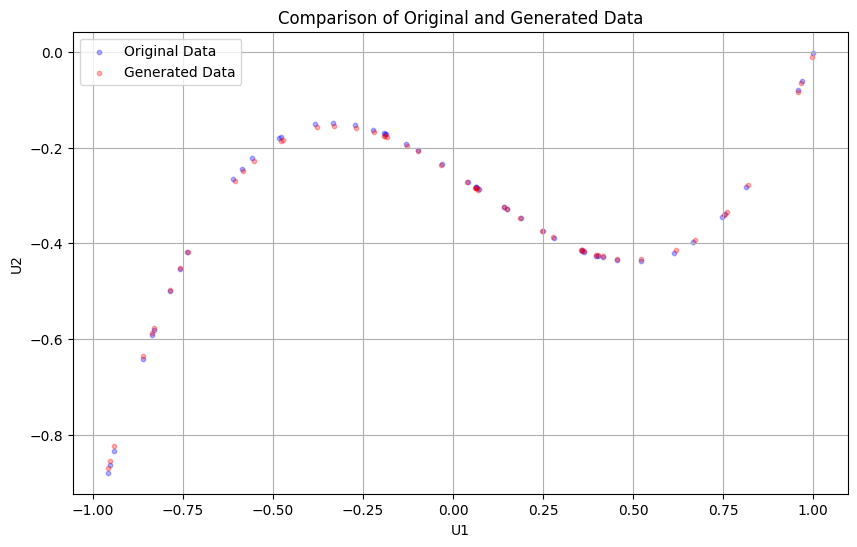

In [33]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])  
        return out, hidden

input_size = 2  
hidden_size = 50  
num_layers = 1  
output_size = input_size  
gru_model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)


X_gru = X.unsqueeze(1)  

num_epochs = 500
for epoch in range(num_epochs):
    hidden = None  
    for batch_features, _ in data_loader:
        
        optimizer.zero_grad()
        
        
        batch_features = batch_features.unsqueeze(1).to(device)
        
        
        outputs, hidden = gru_model(batch_features, hidden)
        
        hidden = hidden.detach()
        
        loss = criterion(outputs, batch_features[:, -1, :])
        
        loss.backward()
        optimizer.step()
        
    # output every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


with torch.no_grad():
    
    X_gru = X_gru.to(device)
    generated_data, _ = gru_model(X_gru, None)
    generated_data = generated_data.cpu().numpy()


plt.figure(figsize=(10, 6))
plt.scatter(data['U1'], data['U2'], color='blue', alpha=0.3, s=10, edgecolor='blue', label='Original Data')
plt.scatter(generated_data[:, 0], generated_data[:, 1], color='red', alpha=0.3, s=10, edgecolor='red', label='Generated Data')
plt.legend()
plt.xlabel('U1')
plt.ylabel('U2')
plt.grid(True)
plt.title('Comparison of Original and Generated Data')
plt.show()

